# Empirical Results - Soft Information vs. Hard Information

## Required Libraries

In [1]:
from clustering_utility import *

import os
from pathlib import Path
import json
import pickle

import matplotlib.pylab as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift
import umap

pd.set_option('display.max_colwidth', None)
output_to_cm_font = False # set font of plot outputs
if output_to_cm_font:
    from matplotlib import rc
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    # rc('text', usetex=True)


## Data Preparation

In [2]:
# seed = 9 used for all part of the project for consistency
seed = 9

In [3]:
time_range = list(range(2013,2023))
min_sentence_len_to_collect = 5
firm_list = os.listdir(Path("../../report_data"))
try:
    firm_list.remove(".DS_Store")
except:
    pass
firm_list.sort()
firm_to_index_map = {firm_list[i]:i for i in range(len(firm_list))}
index_to_firm_map = {i:firm_list[i] for i in range(len(firm_list))}

In [4]:
# sbert
with open(Path("../../embedding_data/sbert/sbert_model_metadata_all_mpnet_base_v2.json"), 'r') as f:
    SBERT_model_metadata_all_mpnet_base_v2 = json.load(f)
with open(Path("../../embedding_data/sbert/sbert_encoded_text_normalised_data_all_mpnet_base_v2.pkl"), 'rb') as f:
    sbert_encoded_text_normalised_data_dict = pickle.load(f)

# w2v
with open(Path("../../embedding_data/w2v/w2v_runs/sgns_global_replacement/data_and_model_config.json"), 'r') as f:
    w2v_data_and_model_config = json.load(f)
with open(Path("../../embedding_data/w2v/w2v_runs/sgns_global_replacement/w2v_embedding_firm_token_only.pkl"), 'rb') as f:
    w2v_embedding_firm_token_only = pickle.load(f)

In [5]:
# compute Yearly Average SBERT Embeddings for Each Firm

sbert_encoded_text_normalised_data_dict = calculate_mean_sbert_each_year_each_firm(
    sbert_encoded_text_normalised_data_dict,
    firm_list,
    time_range,
    normalisation_level="docs_level_sentence_list_text_normalised",
)
firm_level_sbert_mean_embedding = calculate_mean_firm_level_embedding(
    time_range, firm_list, sbert_encoded_text_normalised_data_dict, SBERT_model_metadata_all_mpnet_base_v2["num_dimension"]
)
firm_level_sbert_mean_embedding_matrix = collect_mean_firm_level_embedding_to_matrix(
    firm_list, firm_level_sbert_mean_embedding, SBERT_model_metadata_all_mpnet_base_v2["num_dimension"]
)

100%|██████████| 117/117 [00:01<00:00, 79.77it/s] 


In [6]:
# obtain decade consistent G-SIB firm list

all_fi_metadata = pd.read_excel(Path("../../financial_data")/"all_fi_metadata.xlsx")
decad_consistent_gsib_firm_list = all_fi_metadata[all_fi_metadata["10YCSB"]]["Abbreviation"].to_list()
decad_consistent_gsib_firm_list.sort()

gsib_name_to_abbreviation_map = pd.read_excel(Path("../../financial_data/gsib_name_to_abbreviation_map.xlsx"))
gsib_name_to_abbreviation_map_dict = dict(zip(gsib_name_to_abbreviation_map["firm"], gsib_name_to_abbreviation_map["abbreviation"]))

In [7]:
# extract GSIB indicator and GSIB score data

indicator_score_2013_2022_dict = extract_yearly_gsib_data_from_excel(Path("../../financial_data/indicator_value_2013_2022_gsib_score.xlsx"), 2013, 2022)
indicator_score_2013_2022_df = merge_yearly_gsib_data_to_df(indicator_score_2013_2022_dict)
indicator_score_2013_2022_df = indicator_score_2013_2022_df.rename(index=gsib_name_to_abbreviation_map_dict)
indicator_score_2013_2022_df.sort_index(inplace=True)
indicator_score_2013_2022_df = indicator_score_2013_2022_df.dropna()
indicator_score_2013_2022_df.isna().sum().sum()

0

In [8]:
# separate GSIB indicator and GSIB score data to different dataframes

size_score_2013_2022_df = indicator_score_2013_2022_df.filter(like='size', axis=1)
interconn_score_2013_2022_df = indicator_score_2013_2022_df.filter(like='interconn', axis=1)
subs_infra_score_2013_2022_df = indicator_score_2013_2022_df.filter(like='subs_infra', axis=1)
complexity_score_2013_2022_df = indicator_score_2013_2022_df.filter(like='complexity', axis=1)
crossjuris_score_2013_2022_df = indicator_score_2013_2022_df.filter(like='crossjuris', axis=1)
gsib_score_2013_2022_df = indicator_score_2013_2022_df.filter(like='gsib', axis=1)

In [9]:
# calculate mean GSIB scores for each firm across 10 years

size_score_mean = size_score_2013_2022_df.mean(axis=1)
interconn_score_mean = interconn_score_2013_2022_df.mean(axis=1)
subs_infra_score_mean = subs_infra_score_2013_2022_df.mean(axis=1)
complexity_score_mean = complexity_score_2013_2022_df.mean(axis=1)
crossjuris_score_mean = crossjuris_score_2013_2022_df.mean(axis=1)
gsib_score_mean = gsib_score_2013_2022_df.mean(axis=1)

In [10]:
indicator_score_mean = pd.concat([size_score_mean, interconn_score_mean, subs_infra_score_mean, complexity_score_mean, crossjuris_score_mean], axis=1)
indicator_score_mean.columns = ['size_score_mean', 'interconn_score_mean', 'subs_infra_score_mean', 'complexity_score_mean', 'crossjuris_score_mean']

## Time Constant Significance (10 years as a whole)

In [11]:
indicator_score_mean_cosine_similarity_matrix = compute_cosine_similarity_matrix(indicator_score_mean)
indicator_score_mean_cosine_similarity_matrix_exp_scaled = exp_scale_to_df(indicator_score_mean_cosine_similarity_matrix, decad_consistent_gsib_firm_list)
indicator_score_mean_cosine_similarity_matrix = pd.DataFrame(indicator_score_mean_cosine_similarity_matrix, columns=decad_consistent_gsib_firm_list, index=decad_consistent_gsib_firm_list)

In [12]:
w2v_cosine_similarity_matrix = compute_cosine_similarity_matrix(w2v_embedding_firm_token_only)
w2v_cosine_similarity_matrix_exp_scaled = exp_scale_to_df(w2v_cosine_similarity_matrix, firm_list).loc[decad_consistent_gsib_firm_list][decad_consistent_gsib_firm_list]
w2v_cosine_similarity_matrix = pd.DataFrame(w2v_cosine_similarity_matrix, columns=firm_list, index=firm_list).loc[decad_consistent_gsib_firm_list][decad_consistent_gsib_firm_list]

In [13]:
sbert_cosine_similarity_matrix = compute_cosine_similarity_matrix(firm_level_sbert_mean_embedding_matrix)
sbert_cosine_similarity_matrix_exp_scaled = exp_scale_to_df(sbert_cosine_similarity_matrix, firm_list).loc[decad_consistent_gsib_firm_list][decad_consistent_gsib_firm_list]
sbert_cosine_similarity_matrix = pd.DataFrame(sbert_cosine_similarity_matrix, columns=firm_list, index=firm_list).loc[decad_consistent_gsib_firm_list][decad_consistent_gsib_firm_list]

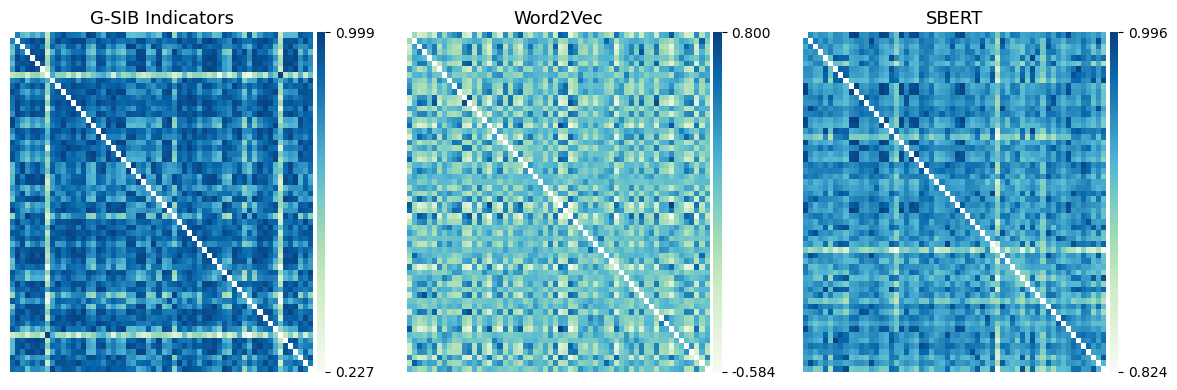

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

sns.heatmap(
    indicator_score_mean_cosine_similarity_matrix,
    cmap="GnBu",
    cbar_kws={"shrink": 1, "aspect": 40, "pad": 0.01, 
              "ticks": [indicator_score_mean_cosine_similarity_matrix.min().min(), indicator_score_mean_cosine_similarity_matrix.max().max()],
              "format": "%.3f"},
    ax=axes[0],
)
axes[0].set_title('G-SIB Indicators', fontsize=13)
axes[0].set_xticks([])
axes[0].set_yticks([])

sns.heatmap(
    w2v_cosine_similarity_matrix,
    cmap="GnBu",
    cbar_kws={"shrink": 1, "aspect": 40, "pad": 0.01, 
              "ticks": [w2v_cosine_similarity_matrix.min().min(), w2v_cosine_similarity_matrix.max().max()],
              "format": "%.3f"},
    ax=axes[1],
)
axes[1].set_title('Word2Vec', fontsize=13)
axes[1].set_xticks([])
axes[1].set_yticks([])

sns.heatmap(
    sbert_cosine_similarity_matrix,
    cmap="GnBu",
    cbar_kws={"shrink": 1, "aspect": 40, "pad": 0.01, 
              "ticks": [sbert_cosine_similarity_matrix.min().min(), sbert_cosine_similarity_matrix.max().max()],
              "format": "%.3f"},
    ax=axes[2],
)
axes[2].set_title('SBERT' , fontsize=13)
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.tight_layout()
plt.savefig(
    Path("../../../tex_source/plots/plots_result/gsib_indicator_vs_w2v_and_sbert_cosine_sim.pdf"), format="pdf"
)
plt.show()

In [15]:
num_permutations = 9999

r_pearson_gsib_vs_w2v, p_value_pearson_gsib_vs_w2v, sig_pearson_gsib_vs_w2v, r_perm_list_pearson_gsib_vs_w2v= permutation_test(
    indicator_score_mean_cosine_similarity_matrix.values,
    w2v_cosine_similarity_matrix.values,
    convert_to_dist = False,
    num_permutations=num_permutations,
    correlation_type="pearson",
    seed=seed
)
r_pearson_gsib_vs_sbert, p_value_pearson_gsib_vs_sbert, sig_pearson_gsib_vs_sbert, r_perm_list_pearson_gsib_vs_sbert = permutation_test(
    indicator_score_mean_cosine_similarity_matrix.values,
    sbert_cosine_similarity_matrix.values,
    convert_to_dist = False,
    num_permutations=num_permutations,
    correlation_type="pearson",
    seed=seed
)

r_spearman_gsib_vs_w2v, p_value_spearman_gsib_vs_w2v, sig_spearman_gsib_vs_w2v, r_perm_list_spearman_gsib_vs_w2v = permutation_test(
    indicator_score_mean_cosine_similarity_matrix.values,
    w2v_cosine_similarity_matrix.values,
    convert_to_dist = False,
    num_permutations=num_permutations,
    correlation_type="spearman",
    seed=seed
)
r_spearman_gsib_vs_sbert, p_value_spearman_gsib_vs_sbert, sig_spearman_gsib_vs_sbert, r_perm_list_spearman_gsib_vs_sbert = permutation_test(
    indicator_score_mean_cosine_similarity_matrix.values,
    sbert_cosine_similarity_matrix.values,
    convert_to_dist = False,
    num_permutations=num_permutations,
    correlation_type="spearman",
    seed=seed
)

r_kt_gsib_vs_w2v, p_value_kt_gsib_vs_w2v, sig_kt_gsib_vs_w2v, r_perm_list_kt_gsib_vs_w2v = permutation_test(
    indicator_score_mean_cosine_similarity_matrix.values,
    w2v_cosine_similarity_matrix.values,
    convert_to_dist = False,
    num_permutations=num_permutations,
    correlation_type="kendalltau",
    seed=seed
)
r_kt_gsib_vs_sbert, p_value_kt_gsib_vs_sbert, sig_kt_gsib_vs_sbert, r_perm_list_kt_gsib_vs_sbert = permutation_test(
    indicator_score_mean_cosine_similarity_matrix.values,
    sbert_cosine_similarity_matrix.values,
    convert_to_dist = False,
    num_permutations=num_permutations,
    correlation_type="kendalltau",
    seed=seed
)

In [16]:
mantel_test_time_constant_df = pd.DataFrame(
    data=[
        ["G-SIB Indicators and Word2Vec", 
         "Pearson",
         r_pearson_gsib_vs_w2v, 
         p_value_pearson_gsib_vs_w2v, 
         sig_pearson_gsib_vs_w2v],
        ["G-SIB Indicators and Word2Vec",
         "Spearman",
         r_spearman_gsib_vs_w2v, 
         p_value_spearman_gsib_vs_w2v, 
         sig_spearman_gsib_vs_w2v],
        ["G-SIB Indicators and Word2Vec",
         "Kendall",
         r_kt_gsib_vs_w2v, 
         p_value_kt_gsib_vs_w2v, 
         sig_kt_gsib_vs_w2v],
        ["G-SIB Indicators and SBERT",
         "Pearson",
         r_pearson_gsib_vs_sbert, 
         p_value_pearson_gsib_vs_sbert,
         sig_pearson_gsib_vs_sbert],
        ["G-SIB Indicators and SBERT", 
         "Spearman",
         r_spearman_gsib_vs_sbert, 
         p_value_spearman_gsib_vs_sbert, 
         sig_spearman_gsib_vs_sbert],
        ["G-SIB Indicators and SBERT",
         "Kendall",
         r_kt_gsib_vs_sbert, 
         p_value_kt_gsib_vs_sbert, 
         sig_kt_gsib_vs_sbert],
    ],
    columns=[f"Mantel Test, Permutation = {num_permutations}  \\\ (Cosine Similarity Matrix)", "Method", "Correlation Coefficient", "p-value", "Significance"],
)
mantel_test_time_constant_df

,"Mantel Test, Permutation = 9999 \\ (Cosine Similarity Matrix)",Method,Correlation Coefficient,p-value,Significance
0,G-SIB Indicators and Word2Vec,Pearson,0.219564,0.0001,***
1,G-SIB Indicators and Word2Vec,Spearman,0.262442,0.0001,***
2,G-SIB Indicators and Word2Vec,Kendall,0.176842,0.0001,***
3,G-SIB Indicators and SBERT,Pearson,0.116244,0.0736,
4,G-SIB Indicators and SBERT,Spearman,0.177306,0.0005,***
5,G-SIB Indicators and SBERT,Kendall,0.118437,0.0005,***


In [17]:
mantel_test_time_constant_df.style.hide().format(na_rep="", precision=4).set_table_styles([
    {'selector': 'small', 'props': ':;'},
    {'selector': 'renewcommand', 'props': ':{\\arraystretch}{1.3};'}
    ], overwrite=False).to_latex(
    buf="../../../tex_source/tables/tables_result/mantel_test_result_gsib_indicator_vs_w2v_and_sbert_table.tex",
    caption="Mantel Test Result between G-SIB Indicator Cosine Similarity Matrix and Word2Vec and SBERT Cosine Similarity Matrix",
    label="tab:mantel_test_table_gsib_indicator_vs_w2v_and_sbert",
    encoding="utf-8",
    hrules=True,
    position_float="centering",
    position="H",
    column_format="lcccc",
)

# {'selector': 'small', 'props': ':;'}
# {'selector': 'fontsize', 'props': ':{11pt}{13pt}\selectfont;'}

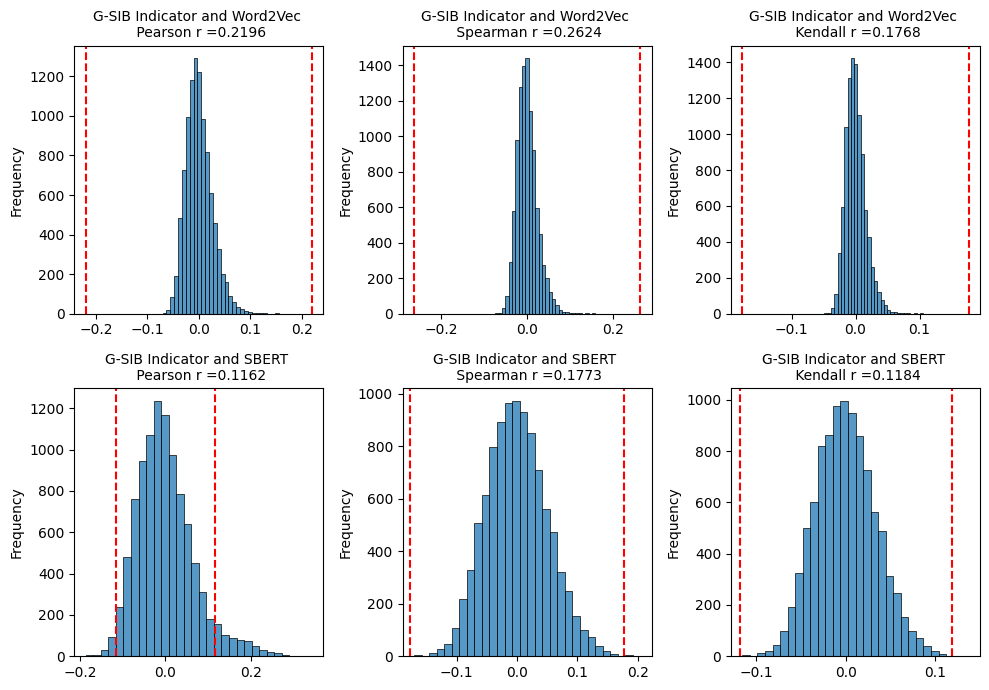

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

sns.histplot(r_perm_list_pearson_gsib_vs_w2v, bins=30, ax=axes[0, 0])
axes[0, 0].axvline(x=r_pearson_gsib_vs_w2v, color='r', linestyle='--')
axes[0, 0].axvline(x=-r_pearson_gsib_vs_w2v, color='r', linestyle='--')
axes[0, 0].set_title(f'G-SIB Indicator and Word2Vec \n Pearson r ={round(r_pearson_gsib_vs_w2v,4)}', fontsize=10)
axes[0, 0].set_ylabel('Frequency')

sns.histplot(r_perm_list_pearson_gsib_vs_sbert, bins=30, ax=axes[1, 0])
axes[1, 0].axvline(x=r_pearson_gsib_vs_sbert, color='r', linestyle='--')
axes[1, 0].axvline(x=-r_pearson_gsib_vs_sbert, color='r', linestyle='--')
axes[1, 0].set_title(f'G-SIB Indicator and SBERT \n Pearson r ={round(r_pearson_gsib_vs_sbert,4)}', fontsize=10)
axes[1, 0].set_ylabel('Frequency')

sns.histplot(r_perm_list_spearman_gsib_vs_w2v, bins=30, ax=axes[0, 1])
axes[0, 1].axvline(x=r_spearman_gsib_vs_w2v, color='r', linestyle='--')
axes[0, 1].axvline(x=-r_spearman_gsib_vs_w2v, color='r', linestyle='--')
axes[0, 1].set_title(f'G-SIB Indicator and Word2Vec \n Spearman r ={round(r_spearman_gsib_vs_w2v,4)}', fontsize=10)
axes[0, 1].set_ylabel('Frequency')

sns.histplot(r_perm_list_spearman_gsib_vs_sbert, bins=30, ax=axes[1, 1])
axes[1, 1].axvline(x=r_spearman_gsib_vs_sbert, color='r', linestyle='--')
axes[1, 1].axvline(x=-r_spearman_gsib_vs_sbert, color='r', linestyle='--')
axes[1, 1].set_title(f'G-SIB Indicator and SBERT \n Spearman r ={round(r_spearman_gsib_vs_sbert,4)}', fontsize=10)
axes[1, 1].set_ylabel('Frequency')

sns.histplot(r_perm_list_kt_gsib_vs_w2v, bins=30, ax=axes[0, 2])
axes[0, 2].axvline(x=r_kt_gsib_vs_w2v, color='r', linestyle='--')
axes[0, 2].axvline(x=-r_kt_gsib_vs_w2v, color='r', linestyle='--')
axes[0, 2].set_title(f'G-SIB Indicator and Word2Vec \n Kendall r ={round(r_kt_gsib_vs_w2v,4)}', fontsize=10)
axes[0, 2].set_ylabel('Frequency')

sns.histplot(r_perm_list_kt_gsib_vs_sbert, bins=30, ax=axes[1, 2])
axes[1, 2].axvline(x=r_kt_gsib_vs_sbert, color='r', linestyle='--')
axes[1, 2].axvline(x=-r_kt_gsib_vs_sbert, color='r', linestyle='--')
axes[1, 2].set_title(f'G-SIB Indicator and SBERT \n Kendall r ={round(r_kt_gsib_vs_sbert,4)}', fontsize=10)
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig(
    Path("../../../tex_source/plots/plots_appendix/mantel_test_result_gsib_indicator_vs_w2v_and_sbert_plot.pdf"), format="pdf"
)
plt.show()

## Time-varying Significance

### Compute Averaged SBERT Dimensional Correlation of Yearly Average Embedding

**Averaged SBERT Dimensional Correlation is computed as follows:**
1. Average sentence embeddings to obtain yearly SBERT embeddings for every financial institution each year:

   $
   E_{\text{SBERT}, f, t} = \frac{1}{V} \sum_{v=1}^{V} \text{SBERT}(\text{sentence}_v)
   $

2. Initialize a tensor $M \in \mathbb{R}^{D\times T\times F}$ where:
   - $D$ is the SBERT embedding dimension, $\forall d \in \{1, \dots, D\}$
   - $T$ is time (year), $\forall t \in \{1, \dots, T\}$
   - $F$ is firm (financial institution), $\forall f \in \{1,\dots, F\}$

3. Populate $M$ using yearly average SBERT embeddings $E_{\text{SBERT}, f, t}$

4. Initialize a tensor $C \in \mathbb{R}^{D\times F\times F}$ for SBERT Dimensional Correlation.

5. Populate $C$ by computing correlations for $\forall d$ across dimension $T$ between $\forall f$ using $M$.

6. Compute the Averaged SBERT Dimensional Correlation Matrix $R_{\text{SBERT-Dimensional}} \in \mathbb{R}^{F \times F}$ by averaging $C$ across dimension $D$.


In [19]:
emb_D = SBERT_model_metadata_all_mpnet_base_v2["num_dimension"] # for all_mpnet_base_v2 model
year_D = len(time_range)
firm_D = len(firm_list)

In [20]:
# initialise a tensor M to store all yearly average embeddings
all_dim_all_year_array_matrix = np.zeros((emb_D, year_D, firm_D))
all_dim_all_year_array_matrix.shape

(768, 10, 117)

In [21]:
# populate M by collecting all yearly average embeddings for each firm, each year and each dimension
for firm in firm_list:
    for i, year in enumerate(time_range):
        for emb_i in range(0, emb_D):
            all_dim_all_year_array_matrix[emb_i][i][firm_to_index_map[firm]] = sbert_encoded_text_normalised_data_dict[firm][str(year)]['yearly_average_sbert_embeddings'][emb_i]

In [22]:
# check shape
all_dim_all_year_array_matrix.shape

(768, 10, 117)

In [23]:
# verify collection
np.any(sbert_encoded_text_normalised_data_dict["hsbc"][str(time_range[6])]['yearly_average_sbert_embeddings'] == all_dim_all_year_array_matrix[:,6,firm_to_index_map["hsbc"]])

True

In [24]:
# check shape
all_dim_all_year_array_matrix[0].shape

(10, 117)

In [25]:
# check shape
np.corrcoef(all_dim_all_year_array_matrix[0], rowvar = False).shape

(117, 117)

In [26]:
# initialise a tensor C
yearly_sbert_dimensional_corr_matrix = np.zeros((emb_D, firm_D, firm_D))
yearly_sbert_dimensional_corr_matrix.shape

(768, 117, 117)

In [27]:
# average embedding correlation across embedding dimension D to obtain firm level dimensional correlation matrix
for emb_i in range(0, emb_D):
    yearly_sbert_dimensional_corr_matrix[emb_i,:,:] = np.corrcoef(all_dim_all_year_array_matrix[emb_i], rowvar = False)

In [28]:
avg_sbert_dimensional_corr_matrix = np.mean(yearly_sbert_dimensional_corr_matrix, axis=0)
avg_sbert_dimensional_corr_matrix.shape

(117, 117)

In [29]:
np.fill_diagonal(avg_sbert_dimensional_corr_matrix, "NaN")
avg_sbert_dimensional_corr_matrix_df = pd.DataFrame(avg_sbert_dimensional_corr_matrix, columns=firm_list, index=firm_list)

In [30]:
# keep only decade consistent GSIB sample firms
avg_sbert_dimensional_corr_matrix_df = avg_sbert_dimensional_corr_matrix_df.loc[decad_consistent_gsib_firm_list][decad_consistent_gsib_firm_list]
avg_sbert_dimensional_corr_matrix_df.shape

(60, 60)

### Compute G-SIB Score Correlation

In [31]:
gsib_score_corr_matrix = np.corrcoef(gsib_score_2013_2022_df, rowvar = True)
np.fill_diagonal(gsib_score_corr_matrix, "NaN")
gsib_score_corr_matrix_df = pd.DataFrame(gsib_score_corr_matrix, columns= gsib_score_2013_2022_df.index, index=gsib_score_2013_2022_df.index)

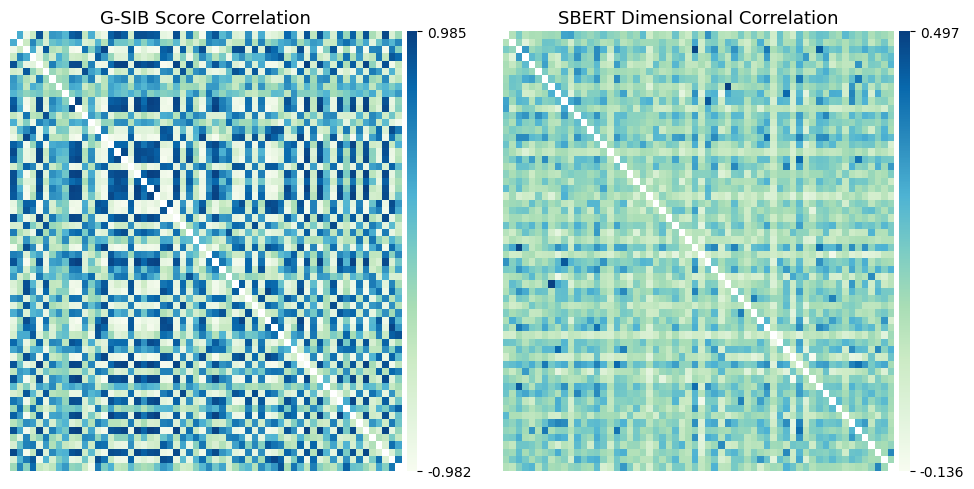

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(
    gsib_score_corr_matrix_df,
    cmap="GnBu",
    cbar_kws={"shrink": 1, "aspect": 40, "pad": 0.01, 
              "ticks": [gsib_score_corr_matrix_df.min().min(), gsib_score_corr_matrix_df.max().max()],
              "format": "%.3f"},
    ax=axes[0],
)
axes[0].set_title('G-SIB Score Correlation', fontsize=13)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel("")
axes[0].set_ylabel("")

sns.heatmap(
    avg_sbert_dimensional_corr_matrix_df,
    cmap="GnBu",
    cbar_kws={"shrink": 1, "aspect": 40, "pad": 0.01, 
              "ticks": [avg_sbert_dimensional_corr_matrix_df.min().min(), avg_sbert_dimensional_corr_matrix_df.max().max()],
              "format": "%.3f"},
    ax=axes[1],
)
axes[1].set_title('SBERT Dimensional Correlation', fontsize=13)
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout()
plt.savefig(
    Path("../../../tex_source/plots/plots_result/gsib_score_vs_sbert_dimensional_corr.pdf"), format="pdf"
)
plt.show()

In [33]:
num_permutations = 9999

r_pearson_gsib_corr_vs_sbert_corr, p_value_pearson_gsib_corr_vs_sbert_corr, sig_pearson_gsib_corr_vs_sbert_corr, r_perm_list_pearson_gsib_corr_vs_sbert_corr = permutation_test(
    gsib_score_corr_matrix_df.values,
    avg_sbert_dimensional_corr_matrix_df.values,
    convert_to_dist = True,
    num_permutations=num_permutations,
    correlation_type="pearson",
    seed=seed
)

r_spearman_gsib_corr_vs_sbert_corr, p_value_spearman_gsib_corr_vs_sbert_corr, sig_spearman_gsib_corr_vs_sbert_corr, r_perm_list_spearman_gsib_corr_vs_sbert_corr = permutation_test(
    gsib_score_corr_matrix_df.values,
    avg_sbert_dimensional_corr_matrix_df.values,
    convert_to_dist = True,
    num_permutations=num_permutations,
    correlation_type="spearman",
    seed=seed
)

r_kt_gsib_corr_vs_sbert_corr, p_value_kt_gsib_corr_vs_sbert_corr, sig_kt_gsib_corr_vs_sbert_corr, r_perm_list_kt_gsib_corr_vs_sbert_corr = permutation_test(
    gsib_score_corr_matrix_df.values,
    avg_sbert_dimensional_corr_matrix_df.values,
    convert_to_dist = True,
    num_permutations=num_permutations,
    correlation_type="kendalltau",
    seed=seed
)


In [34]:
mantel_test_time_varying_df = pd.DataFrame(
    data=[
        ["G-SIB Score and SBERT (Dimensional)",
         "Pearson",
         r_pearson_gsib_corr_vs_sbert_corr, 
         p_value_pearson_gsib_corr_vs_sbert_corr, 
         sig_pearson_gsib_corr_vs_sbert_corr],
        ["G-SIB Score and SBERT (Dimensional) ",
         "Spearman",
         r_spearman_gsib_corr_vs_sbert_corr, 
         p_value_spearman_gsib_corr_vs_sbert_corr, 
         sig_spearman_gsib_corr_vs_sbert_corr],
        ["G-SIB Score and SBERT (Dimensional)",
         "Kendall",
         r_kt_gsib_corr_vs_sbert_corr, 
         p_value_kt_gsib_corr_vs_sbert_corr, 
         sig_kt_gsib_corr_vs_sbert_corr],
    ],
    columns=[f"Mantel Test, Permutation = {num_permutations}  \\\ (Correlation Matrix)", "Method", "Correlation Coefficient", "p-value", "Significance"],
)
mantel_test_time_varying_df

,"Mantel Test, Permutation = 9999 \\ (Correlation Matrix)",Method,Correlation Coefficient,p-value,Significance
0,G-SIB Score and SBERT (Dimensional),Pearson,0.056864,0.0174,*
1,G-SIB Score and SBERT (Dimensional),Spearman,0.039066,0.0846,
2,G-SIB Score and SBERT (Dimensional),Kendall,0.026174,0.0831,


In [35]:
mantel_test_time_varying_df.style.hide().format(na_rep="", precision=4).set_table_styles([
    {'selector': 'small', 'props': ':;'},
    {'selector': 'renewcommand', 'props': ':{\\arraystretch}{1.3};'}
    ], overwrite=False).to_latex(
    buf="../../../tex_source/tables/tables_result/mantel_test_result_gsib_score_corr_vs_sbert_dim_corr_table.tex",
    caption="Mantel Test Result between G-SIB Score Correlation Matrix and SBERT Dimensional Correlation Matrix",
    label="tab:mantel_test_result_gsib_score_corr_vs_sbert_dim_corr_table",
    encoding="utf-8",
    hrules=True,
    position_float="centering",
    position="H",
    column_format="lcccc",
)

# {'selector': 'small', 'props': ':;'}
# {'selector': 'fontsize', 'props': ':{11pt}{13pt}\selectfont;'}

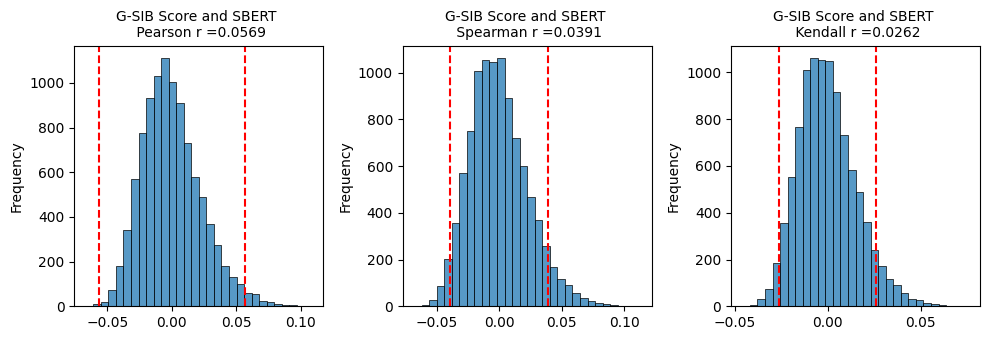

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))

sns.histplot(r_perm_list_pearson_gsib_corr_vs_sbert_corr, bins=30, ax=axes[0])
axes[0].axvline(x=r_pearson_gsib_corr_vs_sbert_corr, color='r', linestyle='--')
axes[0].axvline(x=-r_pearson_gsib_corr_vs_sbert_corr, color='r', linestyle='--')
axes[0].set_title(f'G-SIB Score and SBERT \n Pearson r ={round(r_pearson_gsib_corr_vs_sbert_corr,4)}', fontsize=10)
axes[0].set_ylabel('Frequency')

sns.histplot(r_perm_list_spearman_gsib_corr_vs_sbert_corr, bins=30, ax=axes[1])
axes[1].axvline(x=r_spearman_gsib_corr_vs_sbert_corr, color='r', linestyle='--')
axes[1].axvline(x=-r_spearman_gsib_corr_vs_sbert_corr, color='r', linestyle='--')
axes[1].set_title(f'G-SIB Score and SBERT \n Spearman r ={round(r_spearman_gsib_corr_vs_sbert_corr,4)}', fontsize=10)
axes[1].set_ylabel('Frequency')

sns.histplot(r_perm_list_kt_gsib_corr_vs_sbert_corr, bins=30, ax=axes[2])
axes[2].axvline(x=r_kt_gsib_corr_vs_sbert_corr, color='r', linestyle='--')
axes[2].axvline(x=-r_kt_gsib_corr_vs_sbert_corr, color='r', linestyle='--')
axes[2].set_title(f'G-SIB Score and SBERT \n Kendall r ={round(r_kt_gsib_corr_vs_sbert_corr,4)}', fontsize=10)
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig(
    Path("../../../tex_source/plots/plots_appendix/mantel_test_result_gsib_score_vs_sbert_dim_corr_plot.pdf"), format="pdf"
)
plt.show()

## Clustering using SBERT Dimensional Correlation Matrix 

In [38]:
avg_sbert_dimensional_corr_matrix_exp_scaled = exp_scale_to_df(avg_sbert_dimensional_corr_matrix_df.values, firm_list=decad_consistent_gsib_firm_list)
avg_sbert_dimensional_corr_matrix_exp_scaled = pd.DataFrame(avg_sbert_dimensional_corr_matrix_exp_scaled, columns=decad_consistent_gsib_firm_list, index=decad_consistent_gsib_firm_list) # for embedding comparison later
avg_sbert_dimensional_corr_G_weighted = create_weighted_graph_from_df(avg_sbert_dimensional_corr_matrix_exp_scaled)

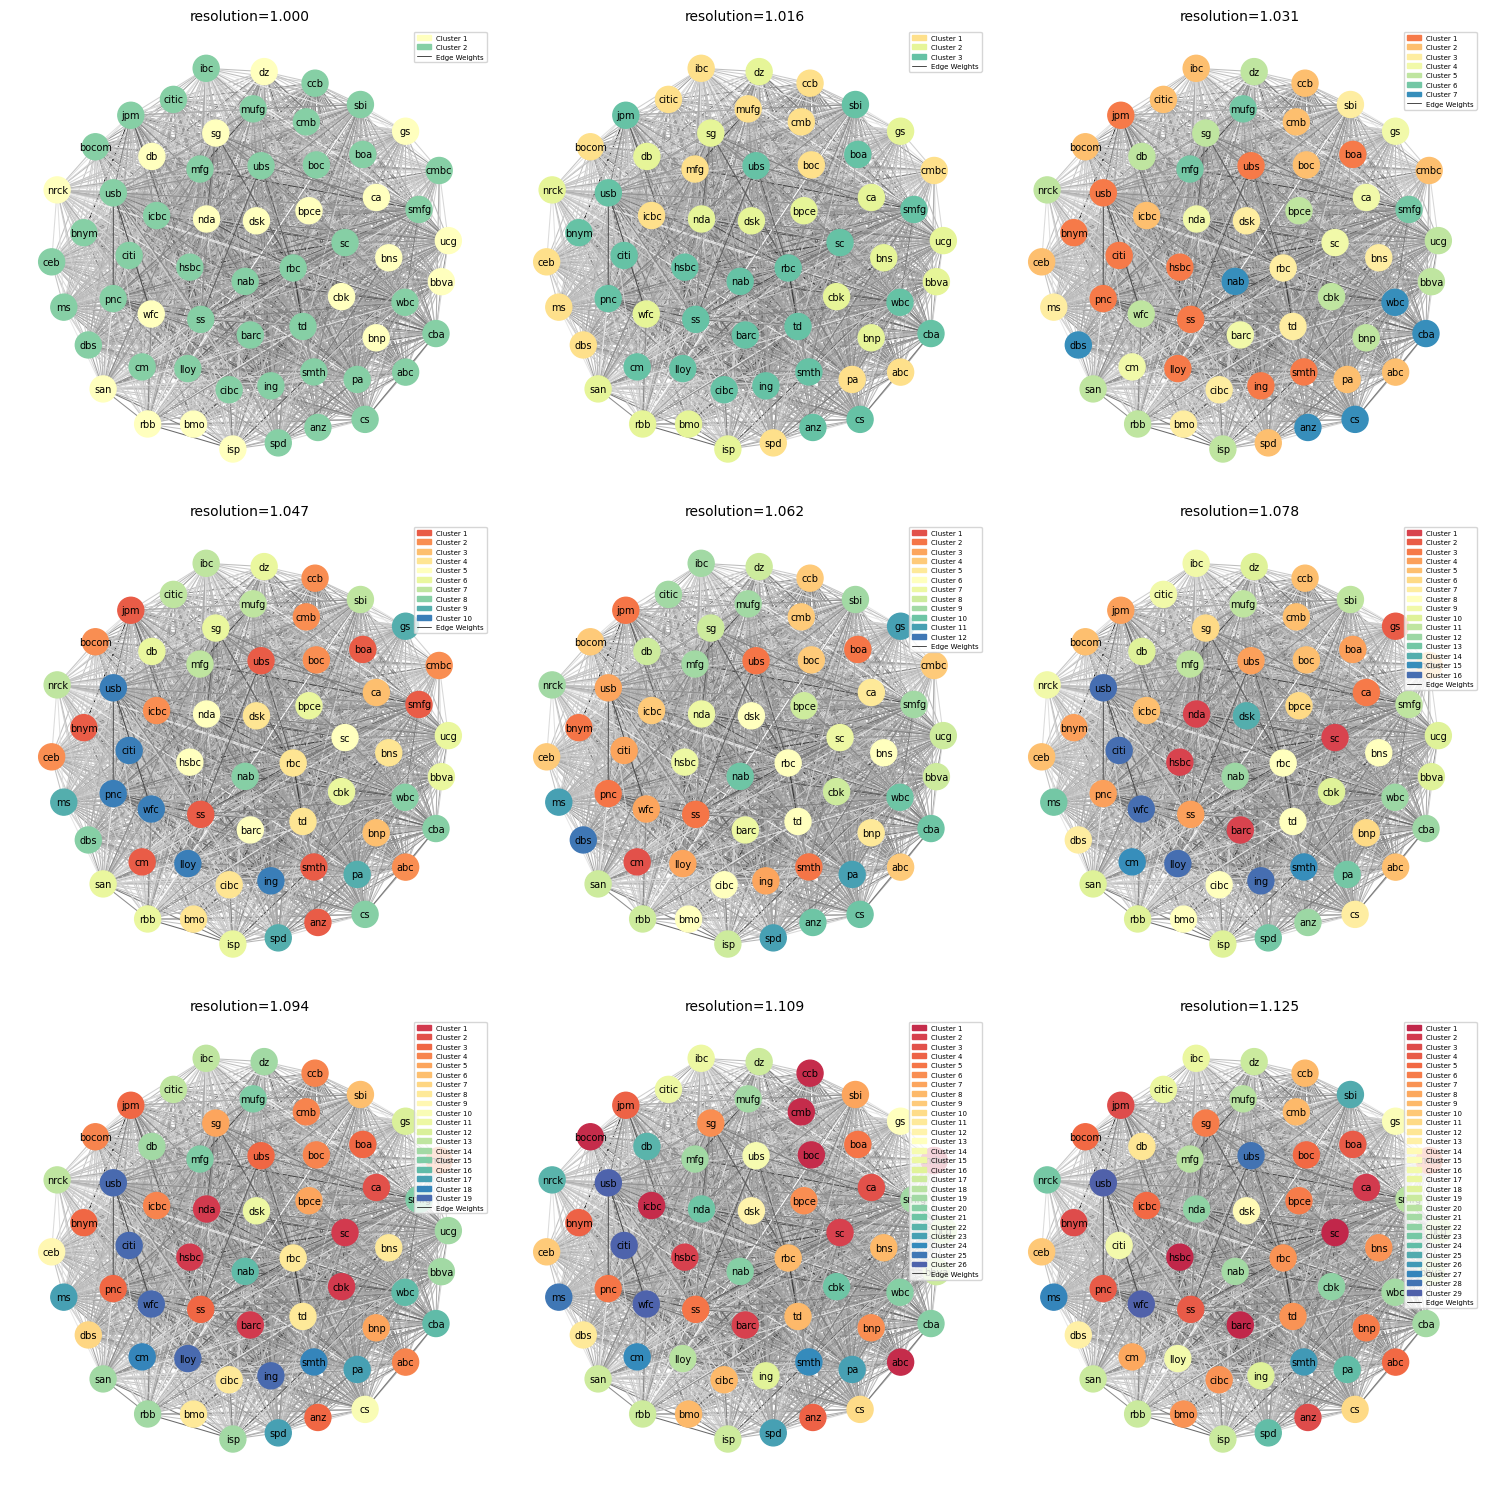

In [39]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

resolution_values = np.linspace(1, 1.125, 9)

# different louvain_communities resolution values plot
for ax, resolution in zip(axes.flatten(), resolution_values):
    sbert_dim_corr_louvain_communities = nx.community.louvain_communities(avg_sbert_dimensional_corr_G_weighted, weight="weight", seed=seed, resolution=resolution)
    edge_weights_dict = nx.get_edge_attributes(avg_sbert_dimensional_corr_G_weighted, 'weight')
    weights = [edge_weights_dict[edge] for edge in avg_sbert_dimensional_corr_G_weighted.edges()]
    
    num_communities = len(sbert_dim_corr_louvain_communities)
    exclude_first_n_color = 2
    colors = [
        plt.cm.Spectral(i / (num_communities + exclude_first_n_color))
        for i in range(num_communities + exclude_first_n_color)
    ][
        exclude_first_n_color : num_communities + exclude_first_n_color
    ]  # Create a color map for the communities, adjusted to exclude the first n color (too dark)

    # Create a dictionary to map nodes to their community colors
    node_color_map = {}
    sbert_dim_corr_louvain_communities_with_color_and_label = {}
    for community_index, community in enumerate(sbert_dim_corr_louvain_communities):
        sbert_dim_corr_louvain_communities_with_color_and_label[f"Cluster {community_index+1}"] = {"color": colors[community_index], "nodes": community}
        for node in community:
            node_color_map[node] = colors[community_index]
    node_colors = [node_color_map[node] for node in avg_sbert_dimensional_corr_G_weighted.nodes()]

    # Generate layout for the graph
    pos = nx.spring_layout(avg_sbert_dimensional_corr_G_weighted, seed=seed, iterations=5000, threshold=1e-9)
    
    # Plot the graph
    nx.draw(
        avg_sbert_dimensional_corr_G_weighted,
        pos,
        with_labels=True,
        node_size=350,
        node_color=node_colors,
        font_size=7,
        font_weight="normal",
        font_color="black",
        edge_color=weights,
        edge_cmap=plt.cm.binary,
        width=0.75,
        ax=ax
    )

    patches = [mpatches.Patch(color=color['color'], label=label) for label, color in sbert_dim_corr_louvain_communities_with_color_and_label.items()]
    edge_line = mlines.Line2D([], [], color='black', linewidth=0.5, label='Edge Weights') # add edge weight line to legend

    ax.legend(handles=patches+[edge_line], prop={"size": 5}, loc="upper right")
    ax.set_title(f"resolution={resolution:.3f}", fontsize=10)

plt.tight_layout()
plt.show()

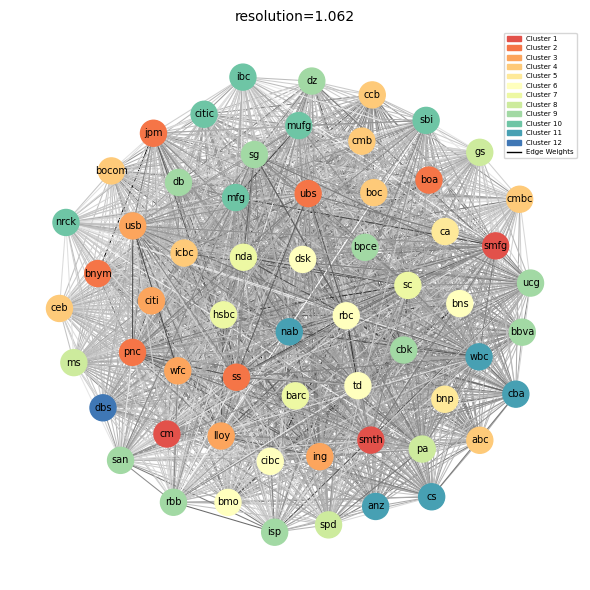

{'Cluster 1': 'smfg, cm, smth',
 'Cluster 2': 'jpm, pnc, ubs, boa, ss, bnym',
 'Cluster 3': 'usb, citi, ing, wfc, lloy',
 'Cluster 4': 'ccb, bocom, cmbc, boc, icbc, cmb, abc, ceb',
 'Cluster 5': 'bnp, ca',
 'Cluster 6': 'bns, bmo, cibc, td, rbc, dsk',
 'Cluster 7': 'hsbc, nda, sc, barc',
 'Cluster 8': 'spd, ms, gs, pa',
 'Cluster 9': 'bpce, dz, sg, db, isp, rbb, ucg, cbk, bbva, san',
 'Cluster 10': 'sbi, citic, mfg, nrck, ibc, mufg',
 'Cluster 11': 'cs, nab, cba, anz, wbc',
 'Cluster 12': 'dbs'}

In [42]:
best_resolution = 1.062

sbert_louvain_best_communities = nx.community.louvain_communities(avg_sbert_dimensional_corr_G_weighted, weight="weight", seed=seed, resolution=best_resolution)
edge_weights_dict = nx.get_edge_attributes(avg_sbert_dimensional_corr_G_weighted, 'weight')
weights = [edge_weights_dict[edge] for edge in avg_sbert_dimensional_corr_G_weighted.edges()]

sbert_louvain_best_num_communities = len(sbert_louvain_best_communities)
exclude_first_n_color = 2
colors = [
    plt.cm.Spectral(i / (sbert_louvain_best_num_communities + exclude_first_n_color))
    for i in range(sbert_louvain_best_num_communities + exclude_first_n_color)
][
    exclude_first_n_color : sbert_louvain_best_num_communities + exclude_first_n_color
]  # Create a color map for the communities, adjusted to exclude the first n color (too dark)

# Create a dictionary to map nodes to their community colors
node_color_map = {}
sbert_louvain_best_communities_with_color_and_label = {}
for community_index, community in enumerate(sbert_louvain_best_communities):
    sbert_louvain_best_communities_with_color_and_label[f"Cluster {community_index+1}"] = {"color": colors[community_index], "nodes": community}
    for node in community:
        node_color_map[node] = colors[community_index]
node_colors = [node_color_map[node] for node in avg_sbert_dimensional_corr_G_weighted.nodes()]

# Generate layout for the graph
pos = nx.spring_layout(avg_sbert_dimensional_corr_G_weighted, seed=seed, iterations=5000, threshold=1e-9)

# Plot the graph
plt.figure(figsize=(6, 6))
nx.draw(
    avg_sbert_dimensional_corr_G_weighted,
    pos,
    with_labels=True,
    node_size=350,
    node_color=node_colors,
    font_size=7,
    font_weight="normal",
    font_color="black",
    edge_color=weights,
    edge_cmap=plt.cm.binary,
    width=0.75,
    ax=plt.gca()
)

patches = [mpatches.Patch(color=color['color'], label=label) for label, color in sbert_louvain_best_communities_with_color_and_label.items()]
edge_line = mlines.Line2D([], [], color='black', linewidth=1, label='Edge Weights') # add edge weight line to legend

plt.legend(handles=patches+[edge_line], prop={"size": 5}, loc="upper right")
plt.title(f"resolution={best_resolution}", fontsize=10)
plt.tight_layout()
plt.show()

louvain_sbert_best_cluster_result = {key: value['nodes'] for key, value in sbert_louvain_best_communities_with_color_and_label.items()}
louvain_sbert_best_cluster_result_joined={}
for cluster in louvain_sbert_best_cluster_result.keys():
    louvain_sbert_best_cluster_result_joined[cluster] = ", ".join(louvain_sbert_best_cluster_result[cluster])
louvain_sbert_best_cluster_result_joined

In [41]:
# louvain_sbert_best_cluster_result_df = pd.DataFrame.from_dict(
#     louvain_sbert_best_cluster_result_joined, orient="index"
# )
# louvain_sbert_best_cluster_result_df.reset_index(inplace=True)
# louvain_sbert_best_cluster_result_df.columns = ["Cluster", "Financial Institution"]
# louvain_sbert_best_cluster_result_df.style.hide().format(na_rep="").set_table_styles([
#     {'selector': 'small', 'props': ':;'}], overwrite=False).to_latex(
#     buf="../../../tex_source/tables/tables_result/TBD.tex",
#     caption="TBD",
#     label="tab:louvain_sbert_best_cluster_result_table",
#     encoding="utf-8",
#     hrules=True,
#     position_float="centering",
#     position="H",
#     column_format="lp{15cm}",
# )
# # {'selector': 'small', 'props': ':;'}
# # {'selector': 'fontsize', 'props': ':{11pt}{13pt}\selectfont;'}